In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../Datasets/Empresas_SABI.csv',decimal=',')

In [3]:
df.head()

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Estado,Código primario CNAE 2009,Ultimo año disponible,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,...,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2,Incidencias Judiciales
0,GRUPO ISOLUX CORSAN CONCESIONES SA,MADRID,Madrid,A85720357,Sociedad anonima,Concurso,6420.0,31/12/2016,406966.0,3024.0,...,NaN,NaN,-5.46,-0.76,1.01,0.07,-99.44,12496.67,-11.76,3.0
1,CORSAN-CORVIAM CONSTRUCCION SA,MADRID,Madrid,A79222709,Sociedad anonima,Concurso,4110.0,31/12/2017,211236.0,304763.0,...,63.82,-95.46,-41.29,-0.30,0.44,-0.30,-22.47,-14.98,-27.99,51.0
2,CODYT SA,BARCELONA,Cataluña,A58358177,Sociedad anonima,Concurso,4634.0,31/12/2009,157068.0,169800.0,...,-72.67,-21.87,NaN,-0.14,0.24,0.54,-2.59,18.82,-45.29,1.0
3,O W BUNKER SPAIN SL,MADRID,Madrid,B84546415,Sociedad limitada,Concurso,4612.0,31/12/2013,152786.0,184556.0,...,NaN,NaN,NaN,2.61,3.04,-0.83,-62.33,-64.04,6.32,1.0
4,THYSSEN ROS CASARES SA,PUIG,Comunidad Valenciana,A46467965,Sociedad anonima,Concurso,2432.0,30/09/2012,133968.0,148255.0,...,-25.33,-30.46,395.31,0.25,0.00,0.37,-90.73,-4.59,776.05,1.0


In [4]:
df.shape

(75517, 282)

In [5]:
dates = df['Ultimo año disponible']

In [6]:
valores = []
for date in dates:
    valores.append(int(date[6:]))

date = pd.DataFrame(valores,columns=['Ult. año disponible'])
dataset = pd.concat([df,date],axis=1)
dataset =  dataset.drop(['Ultimo año disponible'],axis=1)

In [7]:
dataset['Código primario CNAE 2009'] = dataset['Código primario CNAE 2009'].astype(np.float64)
data = dataset[dataset['Ult. año disponible'] >=2014] #Solo cogemos empresas del 2014 hacia delante

In [8]:
(data.Estado == 'Concurso').sum()

2848

In [9]:
CNAE = pd.read_csv('../Datasets/CNAE/CNAE.csv').drop(['Unnamed: 0'],axis=1)

In [10]:
CNAE.head()

,number,description,letter
0,111,"Cultivo de cereales (excepto arroz), legumino...",A
1,112,Cultivo de arroz,A
2,113,"Cultivo de hortalizas, raíces y tubérculos",A
3,114,Cultivo de caña de azúcar,A
4,115,Cultivo de tabaco,A


In [11]:
letter=[]
max_number=[]

for x,z in CNAE.groupby(['letter']):
    letter.append(x)
    max_number.append(max(z['number'].values))
    
convert = list(zip(letter,max_number))
CNAE_values=dataset['Código primario CNAE 2009'].values
print(type(CNAE_values[1]))
valors=[]
for i in CNAE_values:
    flag = True
    for j in convert:
        if (np.isnan(i)) & (flag):
            valors.append(np.nan)
            flag=False
        elif (i <= j[1]) & (flag):
            valors.append(j[0])
            flag=False

<class 'numpy.float64'>


In [12]:
len(valors) == df.shape[0]  # se ha ejecutado de manera correcta tiene el mismo numero de registros

True

Este codigo servira para hacer una nueva variable que en vez de mirar el numero tambien se mirará el sector al que pertecene

In [59]:
CNAE_number = pd.DataFrame({
    'CNAE_Number':valors
})
CNAE_number.shape

(75517, 1)

In [14]:
dataset = pd.concat([dataset,CNAE_number],axis=1)

In [15]:
for i in dataset.columns:
    print(i , dataset[i].isnull().any())

Nombre False
Localidad True
Comunidad autónoma False
Código NIF False
Forma jurídica False
Estado False
Código primario CNAE 2009 True
Ingresos de explotación mil EUR Últ. año disp. True
Ingresos de explotación mil EUR Año - 1 True
Ingresos de explotación mil EUR Año - 2 True
Result. ordinarios antes Impuestos mil EUR Últ. año disp. True
Result. ordinarios antes Impuestos mil EUR Año - 1 True
Result. ordinarios antes Impuestos mil EUR Año - 2 True
Resultado del Ejercicio mil EUR Últ. año disp. True
Resultado del Ejercicio mil EUR Año - 1 True
Resultado del Ejercicio mil EUR Año - 2 True
Total Activo mil EUR Últ. año disp. False
Total Activo mil EUR Año - 1 True
Total Activo mil EUR Año - 2 True
Fondos propios mil EUR Últ. año disp. True
Fondos propios mil EUR Año - 1 True
Fondos propios mil EUR Año - 2 True
Rentabilidad económica (%) % Últ. año disp. False
Rentabilidad económica (%) % Año - 1 True
Rentabilidad económica (%) % Año - 2 True
Rentabilidad financiera (%) % Últ. año disp. Tr

Capital circulante por empleado mil Año - 1 True
Capital circulante por empleado mil Año - 2 True
Total activos por empleado mil Últ. año disp. True
Total activos por empleado mil Año - 1 True
Total activos por empleado mil Año - 2 True
Importe neto Cifra de Ventas % Últ. año disp. True
Importe neto Cifra de Ventas % Año - 1 True
Importe neto Cifra de Ventas % Año - 2 True
Resultados antes de impuestos % Últ. año disp. True
Resultados antes de impuestos % Año - 1 True
Resultados antes de impuestos % Año - 2 True
Consumos de explotación % Últ. año disp. True
Consumos de explotación % Año - 1 True
Consumos de explotación % Año - 2 True
Gastos de personal % Últ. año disp. True
Gastos de personal % Año - 1 True
Gastos de personal % Año - 2 True
Inmovilizado % Últ. año disp. True
Inmovilizado % Año - 1 True
Inmovilizado % Año - 2 True
Total activo % Últ. año disp. True
Total activo % Año - 1 True
Total activo % Año - 2 True
Fondos propios % Últ. año disp. True
Fondos propios % Año - 1 True


In [16]:
dataset = dataset.drop(dataset[dataset.CNAE_Number.isnull()].index)
dataset = dataset.drop(dataset[dataset.Localidad.isnull()].index)
dataset = dataset.drop([75516])
dataset

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Estado,Código primario CNAE 2009,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,Ingresos de explotación mil EUR Año - 2,...,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2,Incidencias Judiciales,Ult. año disponible,CNAE_Number
0,GRUPO ISOLUX CORSAN CONCESIONES SA,MADRID,Madrid,A85720357,Sociedad anonima,Concurso,6420.0,406966.0,3024.0,6008.0,...,-5.46,-0.76,1.01,0.07,-99.44,12496.67,-11.76,3.0,2016,K
1,CORSAN-CORVIAM CONSTRUCCION SA,MADRID,Madrid,A79222709,Sociedad anonima,Concurso,4110.0,211236.0,304763.0,450857.0,...,-41.29,-0.30,0.44,-0.30,-22.47,-14.98,-27.99,51.0,2017,F
2,CODYT SA,BARCELONA,Cataluña,A58358177,Sociedad anonima,Concurso,4634.0,157068.0,169800.0,174135.0,...,NaN,-0.14,0.24,0.54,-2.59,18.82,-45.29,1.0,2009,G
3,O W BUNKER SPAIN SL,MADRID,Madrid,B84546415,Sociedad limitada,Concurso,4612.0,152786.0,184556.0,155779.0,...,NaN,2.61,3.04,-0.83,-62.33,-64.04,6.32,1.0,2013,G
4,THYSSEN ROS CASARES SA,PUIG,Comunidad Valenciana,A46467965,Sociedad anonima,Concurso,2432.0,133968.0,148255.0,107900.0,...,395.31,0.25,0.00,0.37,-90.73,-4.59,776.05,1.0,2012,C
5,ADVEO ESPAÑA SA.,TRES CANTOS,Madrid,A82351867,Sociedad anonima,Concurso,1723.0,115275.0,166307.0,219255.0,...,NaN,0.33,-0.36,0.17,-93.62,48.52,-27.39,1.0,2016,C
6,LSB IBERIA SA.,CASARRUBIOS DEL MONTE,Castilla-La Mancha,A80447618,Sociedad anonima,Concurso,2222.0,109573.0,189668.0,159474.0,...,NaN,0.11,-14.50,-0.01,53.89,154.27,43.02,1.0,2014,C
7,HOGARES NUEVOS ZARAGOZA SL,ZARAGOZA,Aragón,B50860485,Sociedad limitada,Concurso,4110.0,104081.0,63468.0,21171.0,...,8.67,-0.02,0.26,-0.02,148.02,-89.90,-0.45,1.0,2006,F
8,FICOMSA SERVICIOS FINANCIEROS SL,PATERNA,Comunidad Valenciana,B84375468,Sociedad limitada,Concurso,6619.0,101949.0,107605.0,55439.0,...,0.73,-0.68,0.74,3.33,-17.22,76.58,-8.42,1.0,2016,K
9,HERMANOS FARMONI CB,BARCELONA,Cataluña,F08427813,Cooperativa,Concurso,4621.0,101031.0,95081.0,92397.0,...,3.40,0.36,0.25,0.19,-7.78,16.54,53.66,9.0,2017,G


In [17]:
for i in range(7,len(dataset.columns)-1):
    #print(i)
    #if dataset.dtypes[dataset.columns[i]] == 'O':
    dataset[dataset.columns[i]] = dataset[dataset.columns[i]].astype(np.float64)

Text(0.5, 1.0, 'Histograma')

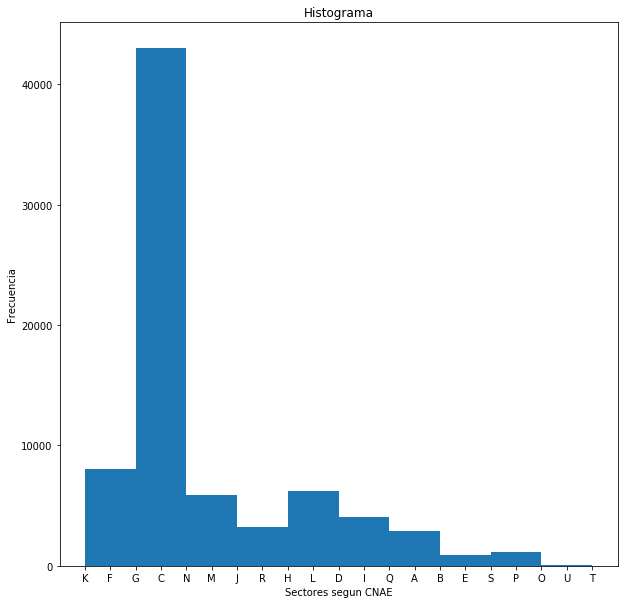

In [18]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.hist(list(dataset.CNAE_Number))
plt.xlabel('Sectores segun CNAE')
plt.ylabel('Frecuencia')
plt.title('Histograma')

In [19]:
for i,value in zip(dataset.dtypes.axes[0],dataset.dtypes.values):
    print(i,value)

Nombre object
Localidad object
Comunidad autónoma object
Código NIF object
Forma jurídica object
Estado object
Código primario CNAE 2009 float64
Ingresos de explotación mil EUR Últ. año disp. float64
Ingresos de explotación mil EUR Año - 1 float64
Ingresos de explotación mil EUR Año - 2 float64
Result. ordinarios antes Impuestos mil EUR Últ. año disp. float64
Result. ordinarios antes Impuestos mil EUR Año - 1 float64
Result. ordinarios antes Impuestos mil EUR Año - 2 float64
Resultado del Ejercicio mil EUR Últ. año disp. float64
Resultado del Ejercicio mil EUR Año - 1 float64
Resultado del Ejercicio mil EUR Año - 2 float64
Total Activo mil EUR Últ. año disp. float64
Total Activo mil EUR Año - 1 float64
Total Activo mil EUR Año - 2 float64
Fondos propios mil EUR Últ. año disp. float64
Fondos propios mil EUR Año - 1 float64
Fondos propios mil EUR Año - 2 float64
Rentabilidad económica (%) % Últ. año disp. float64
Rentabilidad económica (%) % Año - 1 float64
Rentabilidad económica (%) % A

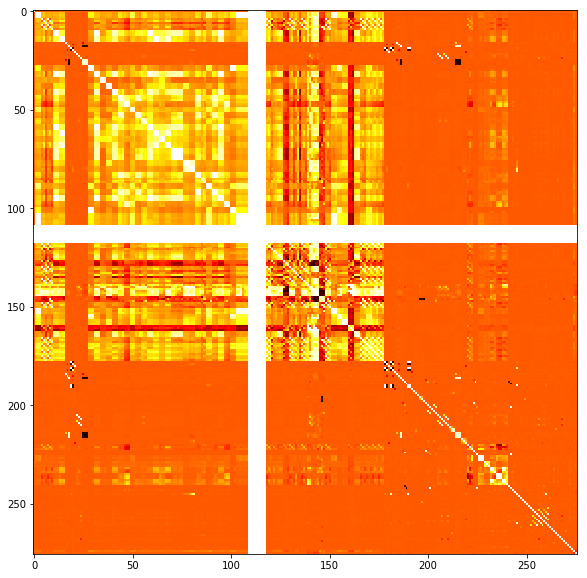

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(dataset.corr(),cmap='hot',interpolation='nearest') #Esta franja en cruz son datos que se encuentran NAN

In [21]:
datos_nulos=dataset.isnull().sum()
delete=datos_nulos[datos_nulos>=35000] #Columnas que contienen mas de la mitad con datos nulos
sup=list(delete.index)
dataset = dataset.drop(sup,axis=1)

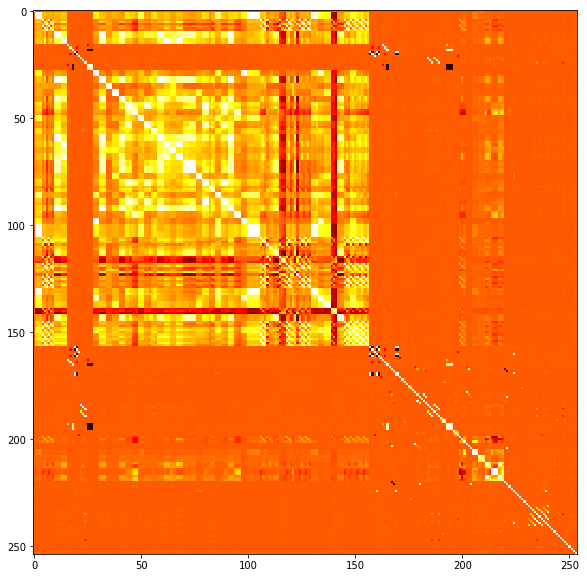

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(dataset.corr(),cmap='hot',interpolation='nearest') #Esta franja en cruz son datos que se encuentran NAN

In [23]:
datos_nulos=dataset.isnull().sum()
datos_nulos

Nombre                                                           0
Localidad                                                        0
Comunidad autónoma                                               0
Código NIF                                                       0
Forma jurídica                                                   0
Estado                                                           0
Código primario CNAE 2009                                        0
Ingresos de explotación mil EUR Últ. año disp.                 680
Ingresos de explotación mil EUR Año - 1                       1656
Ingresos de explotación mil EUR Año - 2                       3954
Result. ordinarios antes Impuestos mil EUR Últ. año disp.      267
Result. ordinarios antes Impuestos mil EUR Año - 1            1013
Result. ordinarios antes Impuestos mil EUR Año - 2            3163
Resultado del Ejercicio mil EUR Últ. año disp.                 292
Resultado del Ejercicio mil EUR Año - 1                       

In [24]:
contador=3
columnas=[]
for i in range(7,len(dataset.columns)-2):
    if contador%3 == 0:
        columnas.append(dataset.columns[i][:-15])
    contador+=1

In [25]:
columnas

['Ingresos de explotación mil EUR',
 'Result. ordinarios antes Impuestos mil EUR',
 'Resultado del Ejercicio mil EUR',
 'Total Activo mil EUR',
 'Fondos propios mil EUR',
 'Rentabilidad económica (%) %',
 'Rentabilidad financiera (%) %',
 'Liquidez general %',
 'Endeudamiento (%) %',
 'Número empleados',
 'Inmovilizado mil EUR',
 'Inmovilizado inmaterial mil EUR',
 'Inmovilizado material mil EUR',
 'Otros activos fijos mil EUR',
 'Activo circulante mil EUR',
 'Existencias mil EUR',
 'Deudores mil EUR',
 'Otros activos líquidos mil EUR',
 'Tesorería mil EUR',
 'Total activo mil EUR',
 'Fondos propios mil EUR Ú',
 'Capital suscrito mil EUR',
 'Otros fondos propios mil EUR',
 'Pasivo fijo mil EUR',
 'Acreedores a L. P. mil EUR',
 'Otros pasivos fijos mil EUR',
 'Pasivo líquido mil EUR',
 'Deudas financieras mil EUR',
 'Acreedores comerciales mil EUR',
 'Otros pasivos líquidos mil EUR',
 'Total pasivo y capital propio mil EUR',
 'Fondo de maniobra mil EUR',
 'Número empleados Ú',
 'Ingreso

Aunque quitemos el ruido en todas las columnas los datos se encuentran aglomerados y  no se encuentran en grupos.


In [26]:
tw = 75000 * 0.2
tw
ntrain = 75000 - tw
(tw * 100) / ntrain   

25.0

Puesto que vamos a hacer tres particiones del dataset 60 para entrenar 20 de validacion y 20 hay que ver para la segunda particion que porcentaje supone un 20 porciento del total en la primera subdivision

In [27]:
X=dataset.drop(['Estado'],axis=1)
y=dataset['Estado']

X_p,X_test,Y_p,Y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=0) #Primera subdivision

X_train,X_val,Y_train,Y_val = train_test_split(X_p,Y_p,test_size = 0.25, stratify = Y_p , random_state = 0)

In [28]:
print(X_train.shape,' Tamaño del entrenamiento',X_val.shape,' Tamaño de validacion', X_test.shape,'Tamaño del test')

(45304, 260)  Tamaño del entrenamiento (15102, 260)  Tamaño de validacion (15102, 260) Tamaño del test


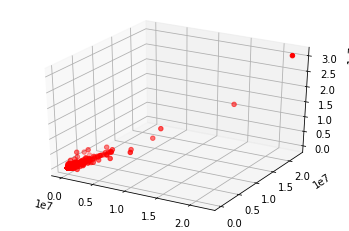

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dataset['Pasivo líquido mil EUR Últ. año disp.'], dataset['Pasivo líquido mil EUR Año - 1'], dataset['Pasivo líquido mil EUR Año - 2'], c='r', marker='o')

In [30]:
columnas_=[]
for i in range(6,len(X_train.columns)-2):
    columnas_.append(X_train.columns[i])

In [31]:
columnas_

['Ingresos de explotación mil EUR Últ. año disp.',
 'Ingresos de explotación mil EUR Año - 1',
 'Ingresos de explotación mil EUR Año - 2',
 'Result. ordinarios antes Impuestos mil EUR Últ. año disp.',
 'Result. ordinarios antes Impuestos mil EUR Año - 1',
 'Result. ordinarios antes Impuestos mil EUR Año - 2',
 'Resultado del Ejercicio mil EUR Últ. año disp.',
 'Resultado del Ejercicio mil EUR Año - 1',
 'Resultado del Ejercicio mil EUR Año - 2',
 'Total Activo mil EUR Últ. año disp.',
 'Total Activo mil EUR Año - 1',
 'Total Activo mil EUR Año - 2',
 'Fondos propios mil EUR Últ. año disp.',
 'Fondos propios mil EUR Año - 1',
 'Fondos propios mil EUR Año - 2',
 'Rentabilidad económica (%) % Últ. año disp.',
 'Rentabilidad económica (%) % Año - 1',
 'Rentabilidad económica (%) % Año - 2',
 'Rentabilidad financiera (%) % Últ. año disp.',
 'Rentabilidad financiera (%) % Año - 1',
 'Rentabilidad financiera (%) % Año - 2',
 'Liquidez general % Últ. año disp.',
 'Liquidez general % Año - 1',


Como podemos ver y tras observar varias variables en este formato no siguen ningun tipo esque me de prediccion por tanto vamos a desarrollar una clase para imputar los valores perdidos de manera automatica

In [32]:
class trainNaN:
    def __init__(self,df,model,columna):
        self.df = copy.copy(df)
        self.columna = columna
        self.columnas = {col:[col+' Últ. año disp.',col+' Año - 1',col+' Año - 2'] for col in columna}
        self.model = copy.copy(model)
        self.models={}
        self.model_q={}
        
    def fit(self):
        
        #print(self.columnas)
        for col in self.columnas:
            data=self.df[self.columnas[col]]
            data=data[data.isnull().any(axis=1) == False]

            data2 = self.df[self.columnas[col]]
            data2 = data2[data2.isnull().any(axis=1)]
            
            contador=0
            models_p = []
            
            for i in self.columnas[col]:
                clon1 = copy.copy(self.model)
                clon2 = copy.copy(self.model)
                clon3 = copy.copy(self.model)
                
                y = data.iloc[:][i]
                X = data.drop([self.columnas[col][contador]],axis=1)
                
                X_p = data.iloc[:][i]
                y_0 = X.drop(X.columns[1],axis=1).iloc[:,0]
                y_1 = X.drop(X.columns[0],axis=1).iloc[:,0]
                
                model_q0 = clon1.fit(pd.DataFrame({'colum':X_p.values}),y_0)
                model_q1 = clon2.fit(pd.DataFrame({'colum':X_p.values}),y_1)
                
                models_01 = [model_q0,model_q1]
                self.model_q[i] = models_01
                
                #print(type(X.iloc[0,0]))
                #print(type(y.loc[0]))
                
                srv = clon3.fit(X,y)
                models_p.append(srv)
                contador += 1
                
            self.models[col] = models_p

            
    def predict(self,testeo,columnas):
        #dataset  =  pd.DataFrame()
        print(testeo.columns)
        print(columnas)
        test_p = testeo.drop(columnas,axis=1)
        test = copy.copy(testeo[columnas])
        #print(dataset)
        #print(self.models)
        contador = 0
        for nrow , row in test.iterrows():
            if(contador % 100 == 0 ):
                print(contador)
            for col in self.columnas:
                row_p = row[self.columnas[col]]
                #print('antes del if')
                if row_p[self.columnas[col]].isnull().sum() == 1:
                    #print('hola he entrado al if')
                    num = list(row_p[self.columnas[col]].isnull()).index(True)
                    X = row_p[list(set(self.columnas[col])-set([self.columnas[col][num]]))]
                    model_=self.models[col][num]
                    #print(model_)
                    row[self.columnas[col][num]]=model_.predict([X.values])[0]
                    #print(row)
                    #print(test)
                    
                elif row_p[self.columnas[col]].isnull().sum() == 2:
                    #print('hola he entrado al elif')
                    null = [i for i in range(3) if row_p[self.columnas[col]].isnull()[i] == True]
                    num = list(row_p[self.columnas[col]].isnull()).index(False)
                    
                    X = [row_p[self.columnas[col][num]]]
                    #print(X)
                    
                    model_0 = self.model_q[self.columnas[col][num]][0]
                    #print(self.model_q[self.columnas[col][num]][0].feature_importances_)
                    row[self.columnas[col][null[0]]] = model_0.predict([X])[0]

                
                    model_1 = self.model_q[self.columnas[col][num]][1]
                    
                    row[self.columnas[col][null[1]]] = model_1.predict([X])[0]
                    #print(row)
                    #print(test)


                    
            contador+=1        
            #print(dataset)
            #data = pd.DataFrame(row)
            #dataset =  pd.concat([dataset,data],axis=1)

                
        test = pd.concat([test_p,test],axis=1)        
        return test


In [33]:
err_colum = [ i for i in range(len(columnas)) if columnas[i][-1] == 'Ú']
err_colum #posiciones donde hay columnas que no tienen el formato apropiado y deben quitarsele la ultima letra.

[20, 32, 33, 39, 42]

In [34]:
for i in err_colum:
    columnas[i] = columnas[i][:-2] # quitamos las dos ultimas posiciones del espacio y de la letra sobrante

In [35]:
tr = DecisionTreeRegressor(max_depth=10)
train_imp = trainNaN(X_train,tr,columnas)
train_imp.fit()

In [ ]:
from sklearn.neural_network import MLPRegressor
nns =  MLPRegressor(hidden_layer_sizes= (2,2),activation ='identity',
                                            solver = 'adam',max_iter =15000)
train_rf = trainNaN(X_train,nns,columnas)
train_rf.fit()

In [ ]:
#svm = SVR(C=0.000000001,gamma=0.001)
lr = LinearRegression()
train_svr=trainNaN(X_train,lr,columnas)
train_svr.fit()

In [102]:
def error(X_vali,train_imp):
    MSE=[]
    X_val = copy.copy(X_vali)
    count = 0
    for col in train_imp.columnas:

        data=X_val[train_imp.columnas[col]]
        data=data[data.isnull().any(axis=1) == False]
        contador=0        
        for i in train_imp.columnas[col]:
            #print(i)
            #print(data)
            y = data.iloc[:][i]
            X = data.drop([train_imp.columnas[col][contador]],axis=1)
            #print(train_imp.columnas[col][contador])
            #print(X)
            y_predict = train_imp.models[col][contador].predict(X)
            #print('he pasado el predict')
            #print(y_predict)
            scaler = MinMaxScaler()
            scaled_y = scaler.fit_transform(pd.DataFrame({'y':y.values}))
            #print(scaled_y)
            scaled_y_predict = scaler.transform(pd.DataFrame({'y_predict':y_predict}))
            #print(scaled_y_predict)

            contador+=1
            scaled_y = np.array([scaled_y[i][0] for i in range(len(y.values))])
            scaled_y_predict = np.array([scaled_y_predict[i][0] for i in range(len(scaled_y_predict))])
            #MSE.append(mean_squared_error([scaled_y[i][0] for i in range(len(y.values)) ],
                                          #[scaled_y[i][0] for i in range(len(scaled_y_predict)) ])) 
            mse = sum( (scaled_y-scaled_y_predict)**2 )
            #print(mse)
            '''
            if count == 176:
                print(scaled_y)
                print(scaled_y_predict)
                print('---------')
                print((scaled_y-scaled_y_predict)**2)
                print(list((scaled_y-scaled_y_predict)**2).index(max((scaled_y-scaled_y_predict)**2)))
                print('---------------------------------------------')
                print(sum( (scaled_y-scaled_y_predict)**2 ))
                print('---------------------------------------------------')
            '''
            MSE.append(mse)
            count += 1
            #print(mse)
            #MSE.append(mean_squared_error(y.values,y_predict))
           
            
    #print('-----------')      
    #print(MSE.index(max(MSE)))
    #print(MSE[MSE.index(max(MSE))])
    return np.array(MSE).mean()

In [103]:
error(X_val,train_imp) # media de la suma de los cuadradados de cada columna

2757786.774215234

In [107]:
error(X_val,train_rf)

2.5863848704394486e+19

In [106]:
from sklearn.neighbors import KNeighborsRegressor
kn = KNeighborsRegressor(n_neighbors=5)
train_kn=trainNaN(X_train,kn,columnas)
train_kn.fit()

In [97]:
error(X_val,train_kn)


176


111922156.03499492

In [99]:
error(X_val,train_nns)

34868     3311.0
32351     3840.0
41004    -3771.0
30032      129.0
18935     4302.0
14249     4724.0
35047      558.0
43298        NaN
2389       217.0
62739      391.0
73416      283.0
69066      235.0
26364      114.0
8335     20247.0
10760     5679.0
48214     1076.0
34223     1592.0
24965     2958.0
18607     1170.0
41858      888.0
2334       944.0
30817     5392.0
45135      794.0
43342      255.0
58217      452.0
69081      864.0
58329      118.0
71386      252.0
12489     4606.0
23564     9017.0
          ...   
33710     3936.0
12307     1045.0
1382       313.0
6648     39316.0
36688     2028.0
57419      993.0
62892     1093.0
42467      282.0
54788      555.0
15947     1491.0
5104        39.0
68712     1505.0
31171     2191.0
3640       107.0
64743      426.0
41241      582.0
9655     32319.0
47154     3575.0
30151      685.0
39996     1859.0
18688     2387.0
20844     1876.0
62569      285.0
42983     1925.0
12792    16064.0
61558      283.0
68681     1095.0
12699     2272

In [ ]:
from time import time
sec = time()
X_train1 = train_imp.predict(X_train,columnas_)
sec_ = time() - sec

In [ ]:
X_train1.to_csv('../Datasets/Empresas_Sabi_SN',index=False)

In [36]:
X_train1 =  pd.read_csv('../Datasets/Empresas_Sabi_SN')

In [37]:
X_train.isnull().sum(axis=0)

Nombre                                                           0
Localidad                                                        0
Comunidad autónoma                                               0
Código NIF                                                       0
Forma jurídica                                                   0
Código primario CNAE 2009                                        0
Ingresos de explotación mil EUR Últ. año disp.                 400
Ingresos de explotación mil EUR Año - 1                       1005
Ingresos de explotación mil EUR Año - 2                       2379
Result. ordinarios antes Impuestos mil EUR Últ. año disp.      149
Result. ordinarios antes Impuestos mil EUR Año - 1             592
Result. ordinarios antes Impuestos mil EUR Año - 2            1898
Resultado del Ejercicio mil EUR Últ. año disp.                 164
Resultado del Ejercicio mil EUR Año - 1                        594
Resultado del Ejercicio mil EUR Año - 2                       

In [38]:
X_train1.isnull().sum(axis=0)

Nombre                                                           0
Localidad                                                        0
Comunidad autónoma                                               0
Código NIF                                                       0
Forma jurídica                                                   0
Código primario CNAE 2009                                        0
Ult. año disponible                                              0
CNAE_Number                                                      0
Ingresos de explotación mil EUR Últ. año disp.                 186
Ingresos de explotación mil EUR Año - 1                        186
Ingresos de explotación mil EUR Año - 2                        186
Result. ordinarios antes Impuestos mil EUR Últ. año disp.       97
Result. ordinarios antes Impuestos mil EUR Año - 1              97
Result. ordinarios antes Impuestos mil EUR Año - 2              97
Resultado del Ejercicio mil EUR Últ. año disp.                

In [39]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train1[columnas_])
X_train2 = imp.transform(X_train1[columnas_])#Quitamos los valores nulos

In [40]:
X_train3 = pd.DataFrame(X_train2,columns=columnas_)
part1 = X_train1.iloc[:,:8]
X_train2 = pd.concat([part1,X_train3],axis=1)
X_train2.isnull().any().any()

False

Una vez que no tenemos ningun valor en nulo en el dataset quitamos la columnas que identifican a las empresas para que estas no provoquen overfiting en los modelos.

In [41]:
X_train2.head(5)

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Código primario CNAE 2009,Ult. año disponible,CNAE_Number,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,PLASFOC SA,SANTA COLOMA DE QUERALT,Cataluña,A43708106,Sociedad anonima,4322.0,2017.0,F,12976.0,10023.0,...,2.29,-4.145000e+01,1.122300e+02,-18.150000,0.41,0.80,-0.18,43.99,-26.30,10.77
1,ADL PARTNER HISPANIA SLU,MADRID,Madrid,B83845776,Sociedad limitada,7311.0,2017.0,M,12279.0,13724.0,...,23.68,1.092695e+06,2.619451e+06,356453.373517,-0.51,3.12,1.06,85.95,-69.18,183.35
2,DISCEMA SA,XIRIVELLA,Comunidad Valenciana,A46246559,Sociedad anonima,4634.0,2017.0,G,46674.0,44254.0,...,-3.25,-2.547000e+01,-1.006000e+01,-16.820000,0.20,1.43,0.03,14.71,5.99,-13.91
3,ALIMENTARIA ASUA SL,ABANTO CIERVANA/ABANTO ZIERBENA,País Vasco,B48959456,Sociedad limitada,4617.0,2010.0,G,3324.0,3537.0,...,-77.03,-9.307000e+01,1.343680e+03,2.170000,-0.83,0.32,4.93,-88.23,1.02,89.53
4,MANUFACTURAS MAHER II SL,NAVARRETE,La Rioja,B26405001,Sociedad limitada,2229.0,2017.0,C,5444.0,3901.0,...,103.12,1.308500e+02,-2.791000e+01,-21.820000,0.16,0.62,1.49,-2.86,93.65,5.82


In [42]:
X_train = X_train2.drop(['Nombre','Localidad','Código NIF','Ult. año disponible',
                         'Código primario CNAE 2009'],axis=1)

In [43]:
X_train.head()

,Comunidad autónoma,Forma jurídica,CNAE_Number,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,Ingresos de explotación mil EUR Año - 2,Result. ordinarios antes Impuestos mil EUR Últ. año disp.,Result. ordinarios antes Impuestos mil EUR Año - 1,Result. ordinarios antes Impuestos mil EUR Año - 2,Resultado del Ejercicio mil EUR Últ. año disp.,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,Cataluña,Sociedad anonima,F,12976.0,10023.0,9694.0,421.0,211.0,179.0,335.0,...,2.29,-4.145000e+01,1.122300e+02,-18.150000,0.41,0.80,-0.18,43.99,-26.30,10.77
1,Madrid,Sociedad limitada,M,12279.0,13724.0,10636.0,278.0,2111.0,2009.0,278.0,...,23.68,1.092695e+06,2.619451e+06,356453.373517,-0.51,3.12,1.06,85.95,-69.18,183.35
2,Comunidad Valenciana,Sociedad anonima,G,46674.0,44254.0,41992.0,1761.0,2031.0,1552.0,1263.0,...,-3.25,-2.547000e+01,-1.006000e+01,-16.820000,0.20,1.43,0.03,14.71,5.99,-13.91
3,País Vasco,Sociedad limitada,G,3324.0,3537.0,3714.0,4.0,11.0,-29.0,3.0,...,-77.03,-9.307000e+01,1.343680e+03,2.170000,-0.83,0.32,4.93,-88.23,1.02,89.53
4,La Rioja,Sociedad limitada,C,5444.0,3901.0,3526.0,1964.0,1224.0,1300.0,1599.0,...,103.12,1.308500e+02,-2.791000e+01,-21.820000,0.16,0.62,1.49,-2.86,93.65,5.82


In [44]:
comu_auto = pd.get_dummies(X_train['Comunidad autónoma'])
form = pd.get_dummies(X_train['Forma jurídica'])
CNAE = pd.get_dummies(X_train['CNAE_Number'])
X_train = X_train.drop(['Comunidad autónoma','Comunidad autónoma','CNAE_Number'],axis=1)
X_train = X_train.drop(['Forma jurídica'],axis=1)
X_train = pd.concat([comu_auto,form,CNAE,X_train],axis=1)

In [45]:
X_train

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla y León,Castilla-La Mancha,Cataluña,Ceuta,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,0,0,0,0,0,0,0,0,1,0,...,2.290000,-4.145000e+01,1.122300e+02,-18.150000,0.41,0.800000,-0.180000,4.399000e+01,-2.630000e+01,10.770000
1,0,0,0,0,0,0,0,0,0,0,...,23.680000,1.092695e+06,2.619451e+06,356453.373517,-0.51,3.120000,1.060000,8.595000e+01,-6.918000e+01,183.350000
2,0,0,0,0,0,0,0,0,0,0,...,-3.250000,-2.547000e+01,-1.006000e+01,-16.820000,0.20,1.430000,0.030000,1.471000e+01,5.990000e+00,-13.910000
3,0,0,0,0,0,0,0,0,0,0,...,-77.030000,-9.307000e+01,1.343680e+03,2.170000,-0.83,0.320000,4.930000,-8.823000e+01,1.020000e+00,89.530000
4,0,0,0,0,0,0,0,0,0,0,...,103.120000,1.308500e+02,-2.791000e+01,-21.820000,0.16,0.620000,1.490000,-2.860000e+00,9.365000e+01,5.820000
5,0,0,0,0,0,0,0,0,0,0,...,13.350000,6.890000e+00,7.832500e+02,20.410000,0.05,0.340000,0.140000,1.666900e+02,1.579000e+01,125.390000
6,0,0,0,0,0,0,0,0,0,0,...,36.820000,-3.200000e-01,-1.150000e+00,54.280000,-0.02,-0.180000,0.340000,-3.198000e+01,-1.283000e+01,68.710000
7,1,0,0,0,0,0,0,0,0,0,...,-15.470000,1.733000e+01,1.008000e+01,90.460000,0.13,-0.190000,-0.170000,5.223000e+01,-1.700000e-01,-14.730000
8,0,0,0,0,0,0,0,0,0,0,...,423.157677,1.768000e+01,2.004700e+02,90.098704,0.31,-7.900000,95.705288,3.696182e+07,-1.000000e+02,124.848333
9,0,0,0,0,0,0,1,0,0,0,...,99590.117255,1.092695e+06,2.619451e+06,356453.373517,-0.25,-0.020000,-0.060000,2.460000e+00,2.415000e+01,14.160000


In [46]:
Y_train[Y_train=='Activa']=1
Y_train[Y_train=='Concurso']=0
Y_train = Y_train.astype(int)

In [47]:
Y_train.head()

21584    1
22365    1
10224    1
60721    1
40489    1
Name: Estado, dtype: int64

In [52]:
(Y_train==0).sum()

3310

In [48]:
X_val1 = train_imp.predict(X_val,columnas_)

Index(['Nombre', 'Localidad', 'Comunidad autónoma', 'Código NIF',
       'Forma jurídica', 'Código primario CNAE 2009',
       'Ingresos de explotación mil EUR Últ. año disp.',
       'Ingresos de explotación mil EUR Año - 1',
       'Ingresos de explotación mil EUR Año - 2',
       'Result. ordinarios antes Impuestos mil EUR Últ. año disp.',
       ...
       'Acreedores a largo plazo % Año - 1',
       'Acreedores a largo plazo % Año - 2',
       'Necesidad fondo maniobra % Últ. año disp.',
       'Necesidad fondo maniobra % Año - 1',
       'Necesidad fondo maniobra % Año - 2', 'Tesorería % Últ. año disp.',
       'Tesorería % Año - 1', 'Tesorería % Año - 2', 'Ult. año disponible',
       'CNAE_Number'],
      dtype='object', length=260)
['Ingresos de explotación mil EUR Últ. año disp.', 'Ingresos de explotación mil EUR Año - 1', 'Ingresos de explotación mil EUR Año - 2', 'Result. ordinarios antes Impuestos mil EUR Últ. año disp.', 'Result. ordinarios antes Impuestos mil EUR Año - 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100


In [53]:
X_val2 = imp.transform(X_val1[columnas_]) #Quitamos los valores nulos

In [54]:
print(X_val2)

[[ 6.52900e+03  6.20100e+03  5.83400e+03 ... -2.01000e+00 -5.01100e+01
   1.11220e+02]
 [ 7.24600e+03  6.51600e+03  5.09900e+03 ... -3.46400e+01 -2.86000e+01
  -4.05100e+01]
 [ 5.36200e+03  3.69300e+03  4.87100e+03 ...  1.42414e+03 -7.45000e+00
  -3.64900e+01]
 ...
 [ 9.36900e+03  9.59100e+03  9.80500e+03 ... -2.33300e+01 -2.16300e+01
  -6.43000e+00]
 [ 5.07800e+03  5.86300e+03  5.08100e+03 ... -2.53400e+01  2.28530e+02
  -6.32800e+01]
 [ 2.72400e+03  1.56000e+03  1.14100e+03 ... -4.88700e+01  6.36800e+01
   1.05910e+02]]


In [52]:
X_val1.shape

(15102, 260)

In [51]:
print(X_val2)

[[ 6.52900e+03  6.20100e+03  5.83400e+03 ... -2.01000e+00 -5.01100e+01
   1.11220e+02]
 [ 7.24600e+03  6.51600e+03  5.09900e+03 ... -3.46400e+01 -2.86000e+01
  -4.05100e+01]
 [ 5.36200e+03  3.69300e+03  4.87100e+03 ...  1.42414e+03 -7.45000e+00
  -3.64900e+01]
 ...
 [ 9.36900e+03  9.59100e+03  9.80500e+03 ... -2.33300e+01 -2.16300e+01
  -6.43000e+00]
 [ 5.07800e+03  5.86300e+03  5.08100e+03 ... -2.53400e+01  2.28530e+02
  -6.32800e+01]
 [ 2.72400e+03  1.56000e+03  1.14100e+03 ... -4.88700e+01  6.36800e+01
   1.05910e+02]]


In [55]:
X_val3 = pd.DataFrame(X_val2,columns=columnas_)
X_val3

,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,Ingresos de explotación mil EUR Año - 2,Result. ordinarios antes Impuestos mil EUR Últ. año disp.,Result. ordinarios antes Impuestos mil EUR Año - 1,Result. ordinarios antes Impuestos mil EUR Año - 2,Resultado del Ejercicio mil EUR Últ. año disp.,Resultado del Ejercicio mil EUR Año - 1,Resultado del Ejercicio mil EUR Año - 2,Total Activo mil EUR Últ. año disp.,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,6529.0,6201.0,5834.000000,618.0,748.000000,406.000000,441.0,617.000000,353.000000,11255.0,...,-59.420000,-1.422000e+01,-1.392000e+01,20669.830000,0.05,-0.280000,-0.150000,-2.010000,-50.110000,111.220000
1,7246.0,6516.0,5099.000000,93.0,131.000000,123.000000,54.0,104.000000,93.000000,2999.0,...,123.840000,1.092695e+06,2.619451e+06,356453.373517,1.15,1.760000,-2.420000,-34.640000,-28.600000,-40.510000
2,5362.0,3693.0,4871.000000,2913.0,-4988.000000,-11238.000000,2913.0,-4988.000000,-6752.000000,142714.0,...,26.810686,-5.978000e+01,-7.290000e+00,172.230000,0.18,0.300000,-0.120000,1424.140000,-7.450000,-36.490000
3,8026.0,6713.0,5857.000000,191.0,76.000000,55.000000,140.0,57.000000,41.000000,2602.0,...,3331.670671,0.000000e+00,0.000000e+00,0.000000,0.15,-2.200000,-0.590000,35.440000,-64.100000,-18.250000
4,15833.0,15251.0,16261.000000,-1000.0,-262.000000,-607.000000,-765.0,-209.000000,-443.000000,4372.0,...,21.660000,-5.575000e+01,-3.855000e+01,1.660000,1.72,-0.370000,-0.160000,-72.680000,-39.980000,-56.280000
5,25083.0,20302.0,16596.000000,1930.0,543.000000,220.000000,1792.0,528.000000,188.000000,19708.0,...,-40.290000,2.192143e+01,1.732000e+01,-43.030000,-0.31,4.960000,-0.890000,59.330000,76.750000,-15.180000
6,6481.0,3920.0,4481.000000,561.0,145.000000,425.000000,420.0,116.000000,334.000000,2118.0,...,-22.720000,1.092695e+06,2.619451e+06,356453.373517,0.16,3.820000,2.720000,-18.760000,113.970000,226.800000
7,5024.0,1508.0,4912.997272,-2144.0,-904.000000,305.779845,-2145.0,-904.000000,122.256766,3881.0,...,1355.842562,1.092695e+06,2.619451e+06,356453.373517,2.09,-1.464174,96.020598,-85.310000,517.887423,281.953511
8,568.0,653.0,543.000000,-10.0,-12.000000,-17.000000,-8.0,-9.000000,-13.000000,139.0,...,20.170000,-5.620000e+00,0.000000e+00,12.970000,1.33,-2.070000,4.050000,-9.460000,62.190000,58.550000
9,3190.0,2595.0,2881.000000,30.0,16.000000,20.000000,23.0,12.000000,15.000000,1545.0,...,1355.842562,-8.460000e+00,2.900000e+00,3.620000,-1.01,-0.320000,3.080000,-59.450000,-7.960000,157.880000


In [58]:
X_val

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Código primario CNAE 2009,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,Ingresos de explotación mil EUR Año - 2,Result. ordinarios antes Impuestos mil EUR Últ. año disp.,...,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2,Ult. año disponible,CNAE_Number
34868,CAMPINGS Y TURISMO SA,TORROELLA DE MONTGRI,Cataluña,A17020645,Sociedad anonima,5530.0,6529.0,6201.0,5834.0,618.0,...,-13.92,20669.83,0.05,-0.28,-0.15,-2.01,-50.11,111.22,2017.0,I
32351,TRANSIT PROJECTES SL,BARCELONA,Cataluña,B59489351,Sociedad limitada,8299.0,7246.0,6516.0,5099.0,93.0,...,NaN,NaN,1.15,1.76,-2.42,-34.64,-28.60,-40.51,2017.0,N
41004,"SOLARIA ENERGIA Y MEDIO AMBIENTE, SA",MADRID,Madrid,A83511501,Sociedad anonima,3519.0,5362.0,3693.0,4871.0,2913.0,...,-7.29,172.23,0.18,0.30,-0.12,1424.14,-7.45,-36.49,2017.0,D
30032,JOSE LUIS DEL MORAL SL,MOLINA DE ARAGON,Castilla-La Mancha,B19104116,Sociedad limitada,4623.0,8026.0,6713.0,5857.0,191.0,...,0.00,0.00,0.15,-2.20,-0.59,35.44,-64.10,-18.25,2017.0,G
18935,PKW LOGISTIK IBERIA S.L.,ZARAGOZA,Aragón,B63723043,Sociedad limitada,8292.0,15833.0,15251.0,16261.0,-1000.0,...,-38.55,1.66,1.72,-0.37,-0.16,-72.68,-39.98,-56.28,2017.0,N
14249,VENICER SA,LEGANES,Madrid,A78455912,Sociedad anonima,4673.0,25083.0,20302.0,16596.0,1930.0,...,17.32,-43.03,-0.31,4.96,-0.89,59.33,76.75,-15.18,2017.0,G
35047,MAVERICK MEDIA SL.,BARCELONA,Cataluña,B65798688,Sociedad limitada,7311.0,6481.0,3920.0,4481.0,561.0,...,NaN,NaN,0.16,3.82,2.72,-18.76,113.97,226.80,2016.0,M
43298,CONSTRUCCIONES Y PROMOCIONES BALZOLA SA CONSTR...,BILBAO,País Vasco,U95423869,Unión temporal de empresas,9499.0,5024.0,1508.0,NaN,-2144.0,...,NaN,NaN,2.09,NaN,NaN,-85.31,NaN,NaN,2007.0,S
2389,ANTONIO GONZALEZ ARAUJO SL,PONTEAREAS,Galicia,B36021673,Sociedad limitada,4511.0,568.0,653.0,543.0,-10.0,...,0.00,12.97,1.33,-2.07,4.05,-9.46,62.19,58.55,2017.0,G
62739,PANEL ARAGON SL,EPILA,Aragón,B99043465,Sociedad limitada,4676.0,3190.0,2595.0,2881.0,30.0,...,2.90,3.62,-1.01,-0.32,3.08,-59.45,-7.96,157.88,2017.0,G


In [61]:
part2 = X_val.drop(columnas_,axis=1)
part2

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Código primario CNAE 2009,Ult. año disponible,CNAE_Number
34868,CAMPINGS Y TURISMO SA,TORROELLA DE MONTGRI,Cataluña,A17020645,Sociedad anonima,5530.0,2017.0,I
32351,TRANSIT PROJECTES SL,BARCELONA,Cataluña,B59489351,Sociedad limitada,8299.0,2017.0,N
41004,"SOLARIA ENERGIA Y MEDIO AMBIENTE, SA",MADRID,Madrid,A83511501,Sociedad anonima,3519.0,2017.0,D
30032,JOSE LUIS DEL MORAL SL,MOLINA DE ARAGON,Castilla-La Mancha,B19104116,Sociedad limitada,4623.0,2017.0,G
18935,PKW LOGISTIK IBERIA S.L.,ZARAGOZA,Aragón,B63723043,Sociedad limitada,8292.0,2017.0,N
14249,VENICER SA,LEGANES,Madrid,A78455912,Sociedad anonima,4673.0,2017.0,G
35047,MAVERICK MEDIA SL.,BARCELONA,Cataluña,B65798688,Sociedad limitada,7311.0,2016.0,M
43298,CONSTRUCCIONES Y PROMOCIONES BALZOLA SA CONSTR...,BILBAO,País Vasco,U95423869,Unión temporal de empresas,9499.0,2007.0,S
2389,ANTONIO GONZALEZ ARAUJO SL,PONTEAREAS,Galicia,B36021673,Sociedad limitada,4511.0,2017.0,G
62739,PANEL ARAGON SL,EPILA,Aragón,B99043465,Sociedad limitada,4676.0,2017.0,G


In [69]:
X_valdef = pd.concat([part2.reset_index(),X_val3],axis=1).drop(['index'],axis=1)
X_valdef

,Nombre,Localidad,Comunidad autónoma,Código NIF,Forma jurídica,Código primario CNAE 2009,Ult. año disponible,CNAE_Number,Ingresos de explotación mil EUR Últ. año disp.,Ingresos de explotación mil EUR Año - 1,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,CAMPINGS Y TURISMO SA,TORROELLA DE MONTGRI,Cataluña,A17020645,Sociedad anonima,5530.0,2017.0,I,6529.0,6201.0,...,-59.420000,-1.422000e+01,-1.392000e+01,20669.830000,0.05,-0.280000,-0.150000,-2.010000,-50.110000,111.220000
1,TRANSIT PROJECTES SL,BARCELONA,Cataluña,B59489351,Sociedad limitada,8299.0,2017.0,N,7246.0,6516.0,...,123.840000,1.092695e+06,2.619451e+06,356453.373517,1.15,1.760000,-2.420000,-34.640000,-28.600000,-40.510000
2,"SOLARIA ENERGIA Y MEDIO AMBIENTE, SA",MADRID,Madrid,A83511501,Sociedad anonima,3519.0,2017.0,D,5362.0,3693.0,...,26.810686,-5.978000e+01,-7.290000e+00,172.230000,0.18,0.300000,-0.120000,1424.140000,-7.450000,-36.490000
3,JOSE LUIS DEL MORAL SL,MOLINA DE ARAGON,Castilla-La Mancha,B19104116,Sociedad limitada,4623.0,2017.0,G,8026.0,6713.0,...,3331.670671,0.000000e+00,0.000000e+00,0.000000,0.15,-2.200000,-0.590000,35.440000,-64.100000,-18.250000
4,PKW LOGISTIK IBERIA S.L.,ZARAGOZA,Aragón,B63723043,Sociedad limitada,8292.0,2017.0,N,15833.0,15251.0,...,21.660000,-5.575000e+01,-3.855000e+01,1.660000,1.72,-0.370000,-0.160000,-72.680000,-39.980000,-56.280000
5,VENICER SA,LEGANES,Madrid,A78455912,Sociedad anonima,4673.0,2017.0,G,25083.0,20302.0,...,-40.290000,2.192143e+01,1.732000e+01,-43.030000,-0.31,4.960000,-0.890000,59.330000,76.750000,-15.180000
6,MAVERICK MEDIA SL.,BARCELONA,Cataluña,B65798688,Sociedad limitada,7311.0,2016.0,M,6481.0,3920.0,...,-22.720000,1.092695e+06,2.619451e+06,356453.373517,0.16,3.820000,2.720000,-18.760000,113.970000,226.800000
7,CONSTRUCCIONES Y PROMOCIONES BALZOLA SA CONSTR...,BILBAO,País Vasco,U95423869,Unión temporal de empresas,9499.0,2007.0,S,5024.0,1508.0,...,1355.842562,1.092695e+06,2.619451e+06,356453.373517,2.09,-1.464174,96.020598,-85.310000,517.887423,281.953511
8,ANTONIO GONZALEZ ARAUJO SL,PONTEAREAS,Galicia,B36021673,Sociedad limitada,4511.0,2017.0,G,568.0,653.0,...,20.170000,-5.620000e+00,0.000000e+00,12.970000,1.33,-2.070000,4.050000,-9.460000,62.190000,58.550000
9,PANEL ARAGON SL,EPILA,Aragón,B99043465,Sociedad limitada,4676.0,2017.0,G,3190.0,2595.0,...,1355.842562,-8.460000e+00,2.900000e+00,3.620000,-1.01,-0.320000,3.080000,-59.450000,-7.960000,157.880000


In [67]:
X_valdef.isnull().any().any()

False

In [70]:
X_val2 = X_valdef.drop(['Nombre','Localidad','Código NIF','Ult. año disponible',
                         'Código primario CNAE 2009'],axis=1)

In [ ]:
comu_auto = pd.get_dummies(X_val2['Comunidad autónoma'])
form = pd.get_dummies(X_val2['Forma jurídica'])
CNAE = pd.get_dummies(X_val2['CNAE_Number'])
X_val2 = X_val2.drop(['Comunidad autónoma','Forma jurídica','CNAE_Number'],axis=1)
X_val2 = pd.concat([comu_auto,form,CNAE,X_val2],axis=1)

In [72]:
X_val2

,Andalucía,Aragón,Asturias,Baleares,Canarias,Cantabria,Castilla y León,Castilla-La Mancha,Cataluña,Ceuta,...,Fondo maniobra % Año - 2,Acreedores a largo plazo % Últ. año disp.,Acreedores a largo plazo % Año - 1,Acreedores a largo plazo % Año - 2,Necesidad fondo maniobra % Últ. año disp.,Necesidad fondo maniobra % Año - 1,Necesidad fondo maniobra % Año - 2,Tesorería % Últ. año disp.,Tesorería % Año - 1,Tesorería % Año - 2
0,0,0,0,0,0,0,0,0,1,0,...,-59.420000,-1.422000e+01,-1.392000e+01,20669.830000,0.05,-0.280000,-0.150000,-2.010000,-50.110000,111.220000
1,0,0,0,0,0,0,0,0,1,0,...,123.840000,1.092695e+06,2.619451e+06,356453.373517,1.15,1.760000,-2.420000,-34.640000,-28.600000,-40.510000
2,0,0,0,0,0,0,0,0,0,0,...,26.810686,-5.978000e+01,-7.290000e+00,172.230000,0.18,0.300000,-0.120000,1424.140000,-7.450000,-36.490000
3,0,0,0,0,0,0,0,1,0,0,...,3331.670671,0.000000e+00,0.000000e+00,0.000000,0.15,-2.200000,-0.590000,35.440000,-64.100000,-18.250000
4,0,1,0,0,0,0,0,0,0,0,...,21.660000,-5.575000e+01,-3.855000e+01,1.660000,1.72,-0.370000,-0.160000,-72.680000,-39.980000,-56.280000
5,0,0,0,0,0,0,0,0,0,0,...,-40.290000,2.192143e+01,1.732000e+01,-43.030000,-0.31,4.960000,-0.890000,59.330000,76.750000,-15.180000
6,0,0,0,0,0,0,0,0,1,0,...,-22.720000,1.092695e+06,2.619451e+06,356453.373517,0.16,3.820000,2.720000,-18.760000,113.970000,226.800000
7,0,0,0,0,0,0,0,0,0,0,...,1355.842562,1.092695e+06,2.619451e+06,356453.373517,2.09,-1.464174,96.020598,-85.310000,517.887423,281.953511
8,0,0,0,0,0,0,0,0,0,0,...,20.170000,-5.620000e+00,0.000000e+00,12.970000,1.33,-2.070000,4.050000,-9.460000,62.190000,58.550000
9,0,1,0,0,0,0,0,0,0,0,...,1355.842562,-8.460000e+00,2.900000e+00,3.620000,-1.01,-0.320000,3.080000,-59.450000,-7.960000,157.880000


In [ ]:
X_val2.to_csv('../Datasets/X_valia')

In [77]:
Y_val[Y_val=='Activa']=1
Y_val[Y_val=='Concurso']=0
Y_val = Y_val.astype(int)

X_val

In [74]:
set(X_train.columns)-set(X_val2.columns)

{'Comunidad de bienes', 'T', 'U'}

In [75]:
X_train_prub = X_train.drop(['Comunidad de bienes', 'T', 'U'],axis=1)

In [78]:
Y_val

34868    1
32351    1
41004    1
30032    1
18935    1
14249    1
35047    1
43298    1
2389     0
62739    1
73416    1
69066    1
26364    1
8335     1
10760    1
48214    1
34223    1
24965    1
18607    1
41858    1
2334     0
30817    1
45135    1
43342    1
58217    1
69081    1
58329    1
71386    1
12489    1
23564    1
        ..
33866    1
43363    1
53878    1
55081    1
56073    1
8515     1
34964    1
42534    1
26027    1
72679    1
62649    1
63179    1
30915    1
18933    1
61861    1
32625    1
37269    1
29692    1
19459    1
16509    1
73711    1
29803    1
28276    1
74793    1
31990    1
62393    1
33058    1
26893    1
42923    1
70886    1
Name: Estado, Length: 15102, dtype: int64

In [80]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

clf = RandomForestClassifier(n_estimators=100,max_depth=10,random_state=0)
#cross_val_score(clf,X_train,Y_train,cv=10,scoring='f1')

clf = clf.fit(X_train_prub,Y_train)
predict = clf.predict(X_val2)
f1_score(predict,Y_val)


0.9938589329452273

In [82]:
clf.n_features_

303

In [78]:
from sklearn.tree import DecisionTreeClassifier
tr = RandomForestClassifier(max_depth=1
                           )
cross_val_score(tr,X_train,Y_train,cv=10)


/usr/local/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/anaconda/lib/python3.7/site-packages/sklearn/

array([0.92694769, 0.92694769, 0.92694769, 0.9397484 , 0.95673289,
       0.95055188, 0.93708609, 0.95629139, 0.94260486, 0.93443709])

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.
clf = GridSearchCV(
    estimator = GradientBoostingClassifier(random_state=seed),
    random_state = seed,
    param_distributions = {'learning_rate' : [0.15,0.2,0.25,0.3,0.35],
                          'n_estimators' : [70,80,90,100,120,140],
                          'max_depth' : [2,3,4,5,6],
                          'loss' : ['deviance','exponential']},
    scoring = 'accuracy',
    cv = 5
)

fitted = clf.fot(X_train,y_train)
print(fitted.best_params_)
print(fitted.best_score_)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier


clf = RandomizedSearchCV(
    estimator = AdaBoostClassifier(random_state=seed,base_estimator=DecisionTreeClassifier(random_state = seed)),
    random_state = seed,
    param_distributions = {'learning_rate' : [1.0,0.9,0.8],
                 'n_estimators' : [90,100,120,140,150,160],
                 'base_estimator__max_depth' : [2,3,4,5,6,7]},
    scoring = 'accuracy',
    cv = 5,
    n_iter = 50
)

fitted1 = clf.fit(X,y)


print(fitted1.best_params_)
print(fitted1.best_score_)

In [ ]:
clf = RandomizedSearchCV(
    estimator = RandomForestClassifier(random_state=seed),
    random_state = seed,
    param_distributions = {'n_estimators' : [50,60,70,80,100,120,140],
                 'criterion' : ['entropy','gini'],
                 'max_features' : [1.0,0.9,0.8,0.7,0.5,0.4,],
                 'max_depth' : [2,3,4,5,6,7,8],
                 'bootstrap' : [True, False]},
    scoring = 'accuracy',
    cv = 4,
    n_iter = 50
)

fitted2 = clf.fit(X,y)


print(fitted2.best_params_)
print(fitted2.best_score_)

In [ ]:
from xgboost import XGBClassifier

model = GridSearchCV(
    estimator = XGBClassifier(),
    param_grid = {'max_depth':[i for i in range(1,21)],'n_iterations':[10,50,100]},
    scoring = 'accuracy',
    cv = 10
)

model = model.fit(X_train,y_train)